In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('/Users/royj/development/LONG-PM-NS-R1_R09_230302094024_S1_TEX.dat')

In [3]:
df

,Chainage,Texture,Dropout
0,0.000659,-7.7,0
1,0.001653,-7.7,0
2,0.002648,-7.3,0
3,0.003642,-7.2,0
4,0.004637,-6.9,0
...,...,...,...
11697,11.633804,2.6,0
11698,11.634799,3.3,0
11699,11.635794,3.5,0
11700,11.636788,3.6,0


In [45]:
# Regression using log values will not work with negative values
# this is because a log of a negative number is undefined !
# find the lowest Texture value 'min(Texture)' 
# make it positive and add it to the texture
# hey presto, all positive values with the plot/graph not changed...

minimum_texture = min(df.Texture)
adjustment_value = abs(minimum_texture)

df.adjusted_Tex = df.Texture + adjustment_value

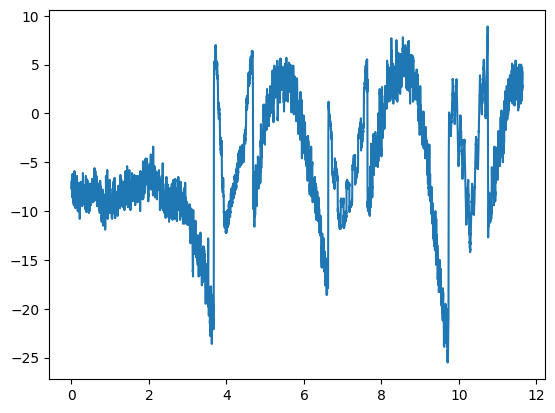

In [46]:
import matplotlib.pyplot as plt

plt.plot(df.Chainage, df.Texture)

In [47]:
import numpy as np
from scipy import signal
data = {}
data['before'] = df.Texture
data['after_fir'] = signal.lfilter(np.ones(len(data)), 1, data['before'])
data['after_iir'] = signal.lfilter([1], [1,-0.5], data['before'])



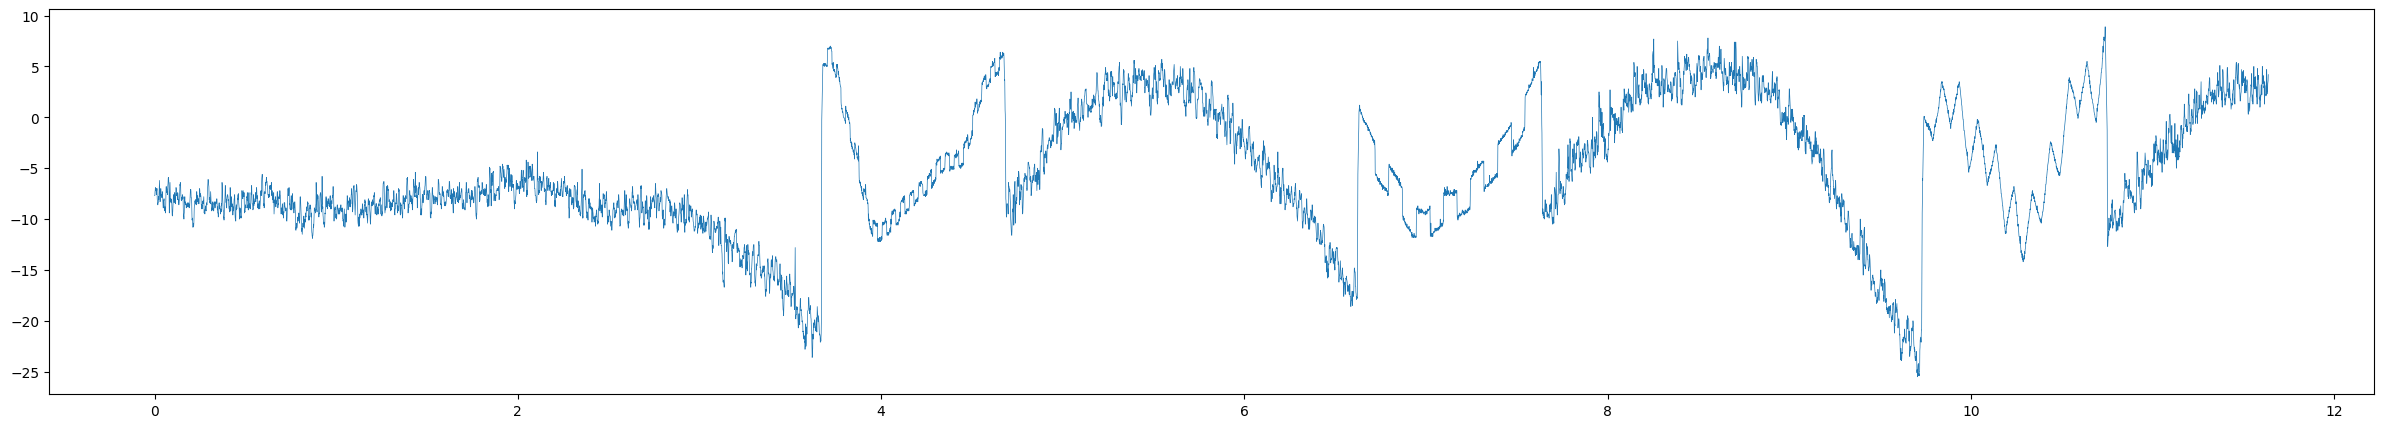

In [68]:
plt.subplots(figsize=(30,5))
#plt.plot(df.Chainage, data['before'], label='before',lw=1)
plt.plot(df.Chainage, data['after_fir'], label='FIR',lw=0.5)
#plt.plot(df.Chainage, data['after_iir'], label='IIR',lw=1)
#plt.subplots(figsize=(10,5))

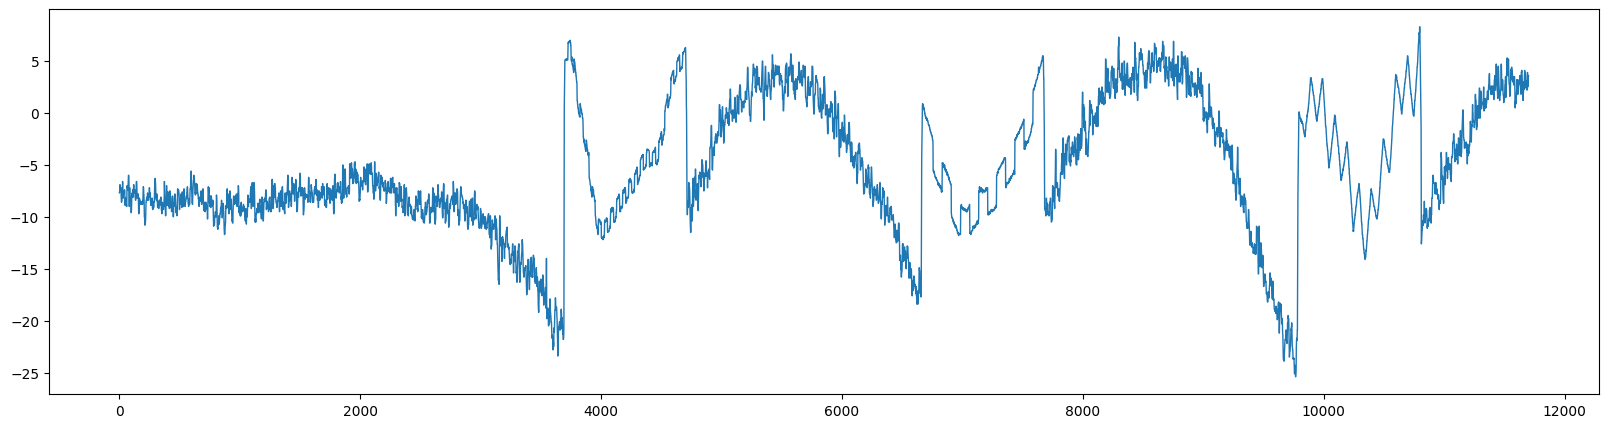

In [49]:
x_med = signal.medfilt(data['before'],3)
plt.subplots(figsize=(20,5))
plt.plot(x_med, label='median',lw=1)

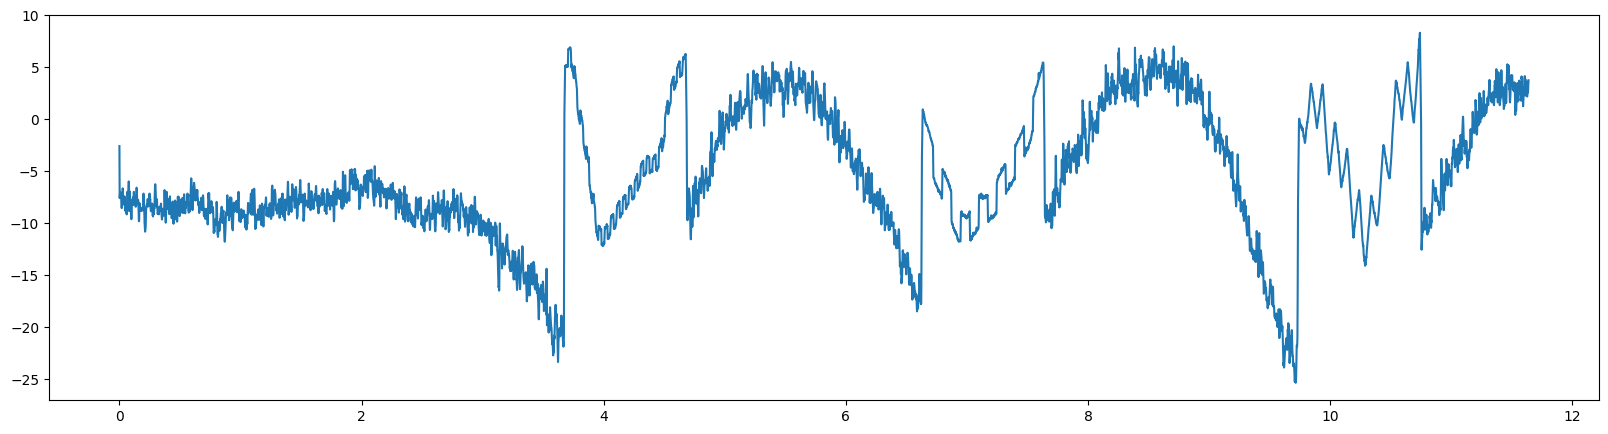

In [72]:
b = np.ones(3)/3
plt.subplots(figsize=(20,5))
x_filt = signal.lfilter(b,1,data['before'])
plt.plot(df.Chainage, x_filt)

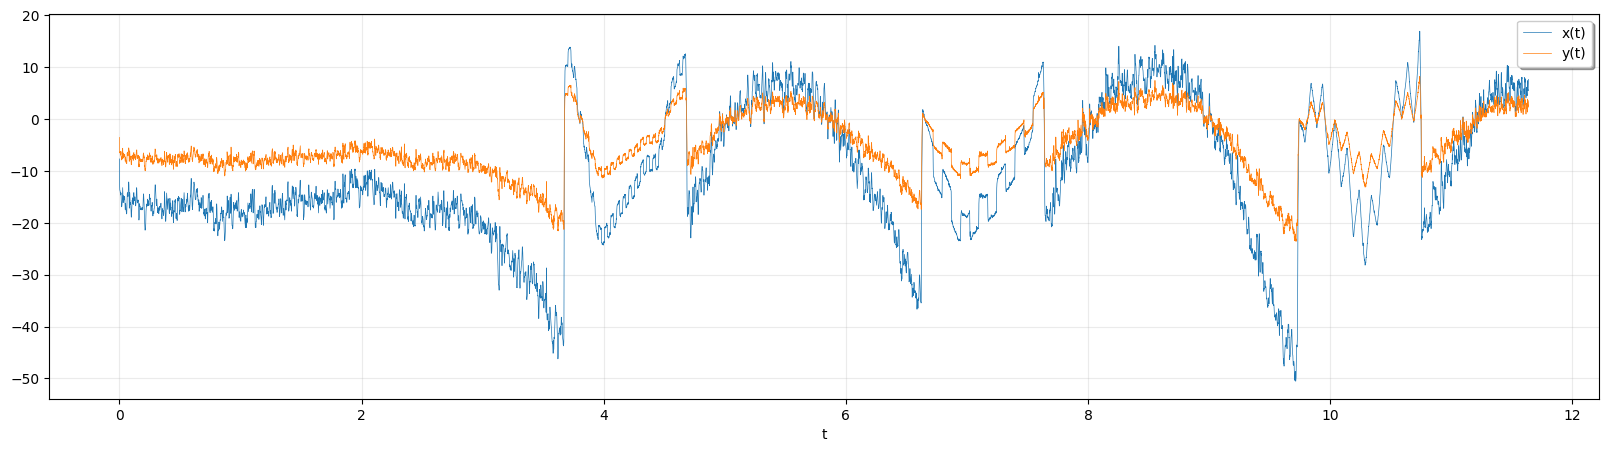

In [97]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

# Load sample data from a WAV file
#sample_rate, data = scipy.io.wavfile.read(df.Texture)
#times = np.arange(len(data))/sample_rate
x=data['after_iir']
#sosfiltfilt(sos.)

sos = butter(6, 0.1, btype='highpass', analog=True, output='sos')
y = sosfiltfilt(sos, x)

from scipy.signal import sosfilt, sosfilt_zi
#sos8 = butter(8, 0.125, output='sos')
#zi = x[:4].mean() * sosfilt_zi(sos8)
#y2, zo = sosfilt(sos8, x, zi=zi)
plt.subplots(figsize=(20,5))
plt.plot(t, x, alpha=1, lw=0.5,label='x(t)')
plt.plot(t, y, label='y(t)', lw=0.5)
#plt.plot(t, y2, label='y2(t)')
plt.legend(framealpha=1, shadow=True)
plt.grid(alpha=0.25)
plt.xlabel('t')
#plt.subplots(figsize=(20,5))
plt.show()

In [65]:
d1 = df.Texture
N = len(d1)
#d1_fft = fft(df.adjusted_Tex)
x_axis = df.Chainage
#f = LinRange(-0.5, 0.5, N+1)[1:N]  # normalized frequency 
fs = 1;   # sampling frequency
fc = 0.005;  # frequency cutoff, less than Fnyquist=0.5
filt = digitalfilter(Highpass(fc,fs=fs), Butterworth(6));
d2 = filtfilt(filt, d1)  #filtered signal
p1 = plot(x_axis[1:N], d2[1:N], lw=1,label="Filtered flipped signal",xlabel="Time", legend=topleft)
#plot!(t[1:N÷2], d3_trunc[1:N÷2], ls=:dash,lc=:black, lw=1,label="From truncated spectrum (100 points)")
plot(p1, size=(4000,1000))

NameError: name 'digitalfilter' is not defined

In [56]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

# Load sample data from a WAV file
sample_rate, data = scipy.io.wavfile.read(df.Texture)
times = np.arange(len(data))/sample_rate

# Apply a 10-50 Hz high-pass filter to the original data
filtered = bandpass(data, [10, 50], sample_rate)

TypeError: expected str, bytes or os.PathLike object, not Series